# Introduction

We are going to use a time series model to predict the number of vehicles on the road.  OCI Data Science allows users to work on data science problems in a Jupyter notebook environment.  In this example, we are going to use a couple of open source tools Statsmodel and Prophet to build time series models.

## Dataset

We are going to use the scm data set, which records the quantity ordered of shipments and the shipment delivery date. We are going to build a model to predict the quantity ordered at a given shipped datetime.

In [ ]:
import pandas as pd
from prophet import Prophet
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
from ads.dataset.factory import DatasetFactory
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
%matplotlib inline

In [ ]:
#!conda install -y -c conda-forge prophet

## Loading the dataset 

The dataset is a csv file stored in OCI-DS


In [ ]:
data = pd.read_csv("Metro_Interstate_quantity_ordered_Edit.csv")

In [ ]:
data.rename(columns={'traffic_volume': 'quantity_ordered'}, inplace=True)

In [ ]:
data=data[['date_time','quantity_ordered']]

In [ ]:
data['ds'] = pd.to_datetime(data["date_time"])

## Exploratory Data Analysis

Next we are going to explore the dataset.

#### Descriptions of the features:

1) date_time: Shipped DateTime Hour of the data collected in local CST time

2) quantity_ordered: Numeric Hourly Quantity of shipment ordered

In [ ]:
data.head()

,date_time,quantity_ordered
0,2012-10-02 09:00:00,5545
1,2012-10-02 10:00:00,4516
2,2012-10-02 11:00:00,4767
3,2012-10-02 12:00:00,5026
4,2012-10-02 13:00:00,4918


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40575 entries, 0 to 48203
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date_time         40575 non-null  object        
 1   quantity_ordered  40575 non-null  int64         
 2   ds                40575 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.2+ MB


In [ ]:
min(data['date_time'])

'2012-10-02 09:00:00'

In [ ]:
max(data['date_time'])

'2018-09-30 23:00:00'

The data set spans from 2012 to 2018. 

### Visualize Dataset

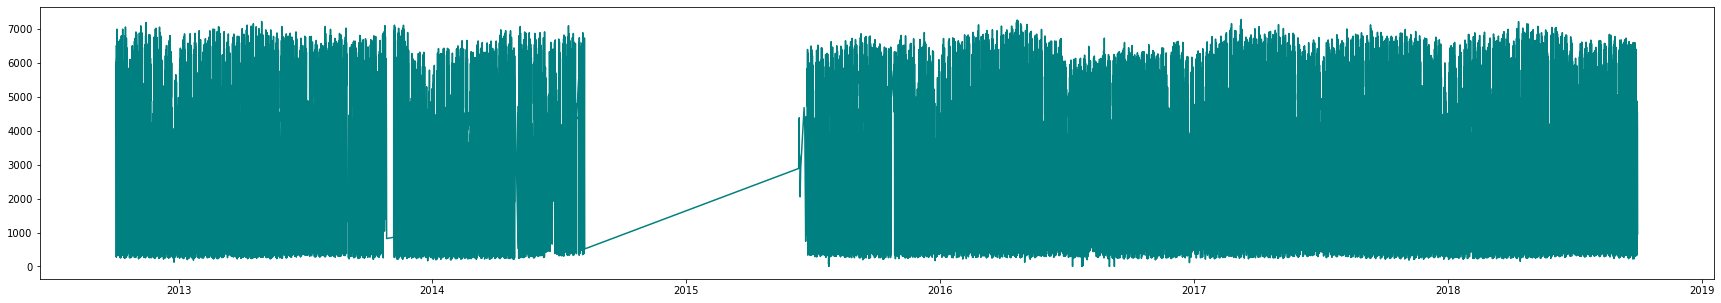

In [ ]:
plt.rcParams['figure.figsize'] = [30, 5]
plt.plot(data['ds'], data['quantity_ordered'])
plt.show()

#### It is a bit hard to see with so much data.  There is missing data in 2015.  Let's plot the data from just the year 2017

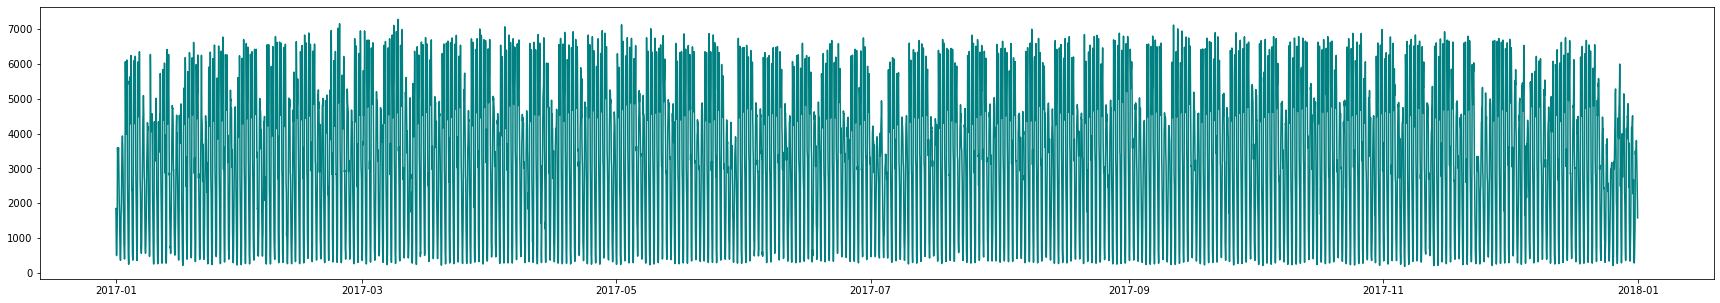

In [ ]:
data_2017 = data[(data['date_time']>'2017-01-01') & (data['date_time']<'2018-01-01')]
plt.plot(data_2017['ds'], data_2017['quantity_ordered'])
plt.show()

#### Let's look at the data for the month of 01/2017

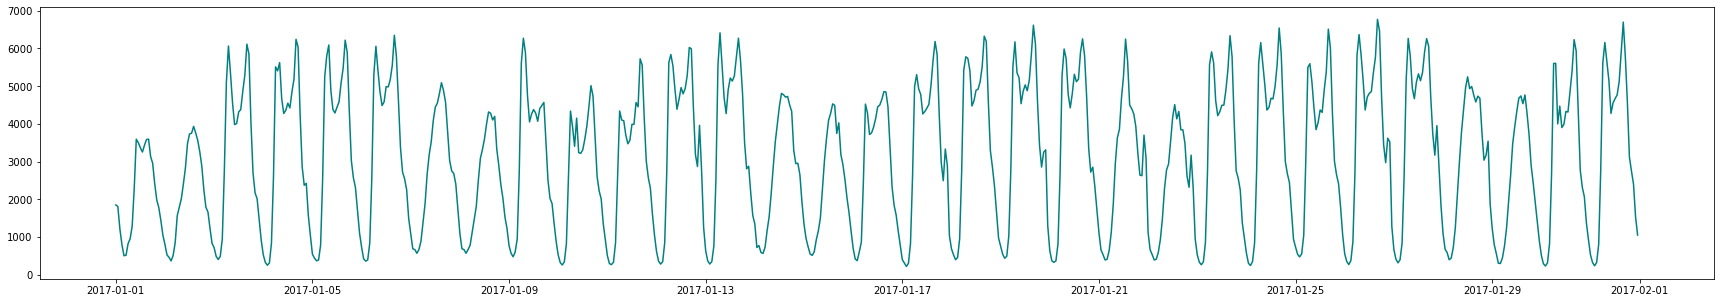

In [ ]:

plt.rcParams['figure.figsize'] = [30, 5]
data_01_2017 = data[(data['date_time']>'2017-01-01') & (data['date_time']<'2017-02-01')]
plt.plot(data_01_2017['ds'], data_01_2017['quantity_ordered'])
plt.show()

#### Let's look at the data for a single day

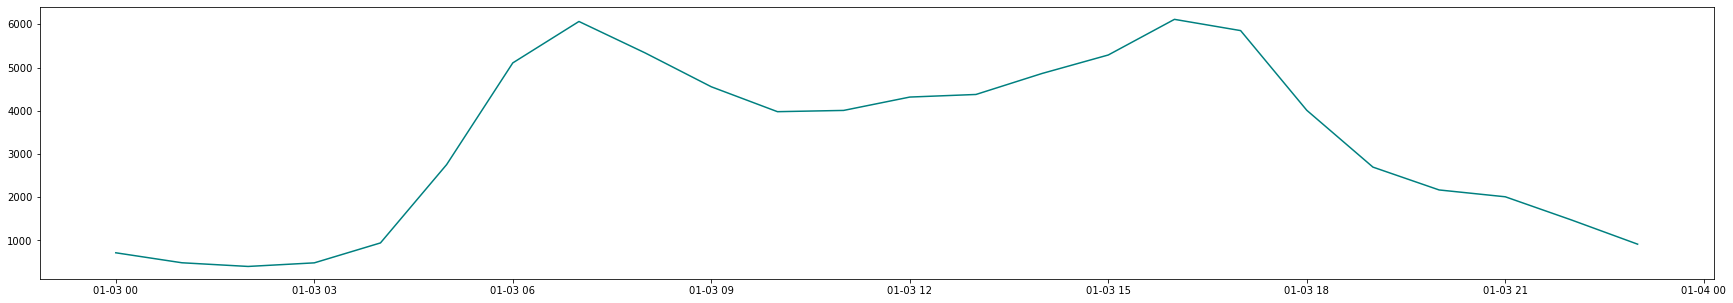

In [ ]:

plt.rcParams['figure.figsize'] = [30, 5]
data_01_03_2017 = data[(data['date_time']>'2017-01-03') & (data['date_time']<'2017-01-04')]
plt.plot(data_01_03_2017['ds'], data_01_03_2017['quantity_ordered'])
plt.show()

In [ ]:
data['weekday'] = data.ds.dt.weekday
data['date'] = data.ds.dt.date
data['hour'] = data.ds.dt.hour
data['month'] = data.ds.dt.month
data['year'] = data.ds.dt.year

### Let's plot the quantity ordered on the different days of the week
0 = Monday
6 = Sunday

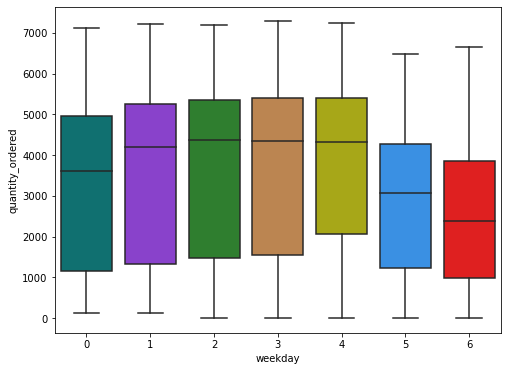

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(x='weekday', y='quantity_ordered', data = data)
plt.show()

### Training data and testing data

Let's use data from 7/1/17 and 7/31/18 to train the model.  We will use the model to predict the hourly quantity ordered for 8/1/18 - 8/31/18.  

In [ ]:
data_subset = data[(data['date_time']>'2017-07-01') & (data['date_time']<'2018-08-01')]
data_subset = data_subset.reset_index(drop = True)

In [ ]:
data_test = data[(data['date_time']>'2018-08-01') & (data['date_time']<'2018-09-01')]

In [ ]:
data_subset_plot = data[(data['date_time']>'2018-07-01') & (data['date_time']<'2018-08-31')]
data_subset_plot = data_subset_plot.reset_index(drop = True)

### Test stationarity of Time Series
A time series is stationary if the statistical properties of the process does not change over time.  For example, the mean and variance are constant over time.  We are going to check if our time series is stationary.  It is often necessary to test for stationarity in time series data because many useful statistical tests and models depend on it.  We are going to use the Augmented Dickey-Fuller test to determine whether the dataset is stationary or not.  The Augmented Dickey-Fuller test tests the null hypothesis that the time series process is not stationary. If the p-value of the test falls below a threshhold value (usually 0.05), then the null hypothesis can be rejected and the data set is stationary.  

We are going to use the open source package Statsmodels to perform the Augmented Dickey-Fuller test.  Statsmodels is one of the pacakges that is a part of the General Machine Learning for CPU conda.

For more information about stationarity of a time series, please visit this [link](https://www.kdnuggets.com/2019/08/stationarity-time-series-data.html)

You can find out more about Statsmodels from the [documentation](https://www.statsmodels.org/stable/index.html)



In [ ]:
from statsmodels.tsa.stattools import adfuller
X = data_subset['quantity_ordered'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.735330
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Because the p-value is much less than 0.05, we can reject the null hypothesis and the time series data is stationary.

We can also plot the moving average and moving standard deviation over the training data to check.

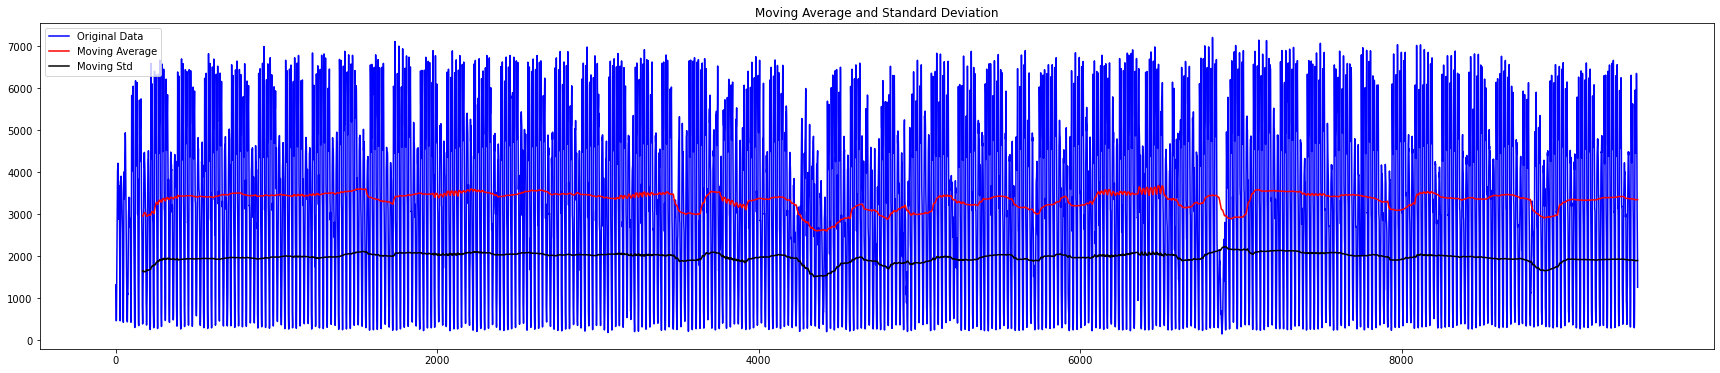

In [ ]:
#Plot moving average and moving standard deviation
plt.figure(figsize=(30,6))
orig = plt.plot(X, color='blue',label='Original Data')
moving_avg = data_subset['quantity_ordered'].rolling(168).mean()
moving_std = data_subset['quantity_ordered'].rolling(168).std()
plt.plot(moving_avg, color='red', label='Moving Average')
plt.plot(moving_std, color='black', label = 'Moving Std')
plt.legend(loc='best')
plt.title('Moving Average and Standard Deviation')
plt.show(block=False)

## ARIMA modeling

ARIMA is a a type of time series forecasting model. It is an acroynm that stands for AutoRegressive Integrated Moving Average. There are three parameters of the model p, d, q. The parameters are defined as follow:

p: auto regressive parameter
d: degree of differencing
q: order of moving average

To determine the parameters of the model, we will use the autocorrelation and partial autocorrelation plots.  You can read more about these plots [here](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

In [ ]:
data_subset = data[(data['date_time']>'2017-07-01') & (data['date_time']<'2018-08-01')]
data_subset = data_subset.reset_index(drop = True)
data_test = data[(data['date_time']>'2018-08-01') & (data['date_time']<'2018-09-01')]

NameError: name 'data' is not defined

In [ ]:
training_data_arima = data_subset[['ds', 'quantity_ordered']]
testing_data_arima = data_test[['ds', 'quantity_ordered']]
training_data_arima.set_index('ds', inplace = True)
testing_data_arima.set_index('ds', inplace = True)


In [ ]:
training_data_arima.index = pd.DatetimeIndex(training_data_arima.index).to_period('H')
testing_data_arima.index = pd.DatetimeIndex(testing_data_arima.index).to_period('H')

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

### Look at the partial autocorrelation plot (pacf) and  autocorrelation (acf) plot

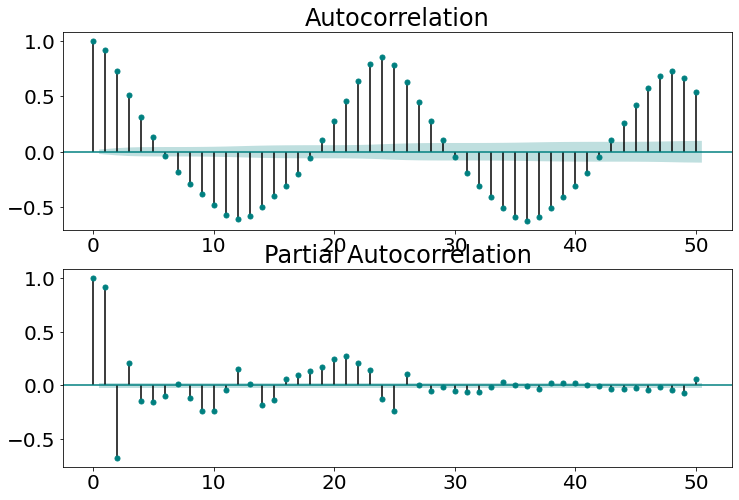

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(training_data_arima['quantity_ordered'], lags=50, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(training_data_arima['quantity_ordered'], lags=50, ax=ax2)

We are going to get the autoregression term p from the partial autocorrelation plot.  From it, it looks like within 2 lags, the autoregression is significant.  We will set the term = 2. 

Since the data is stationary, we are going to set differencing term to 0.

We are going to get the moving average term or q from looking at the autocorrelation plot.   From the plot, we will set the MA term to be 6.


In [ ]:
p= 2
d = 0
q = 6

In [ ]:
arima_model = ARIMA(training_data_arima, order=(p,d,q)).fit()



statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)





In [ ]:
print(arima_model.summary())

                              ARMA Model Results                              
Dep. Variable:       quantity_ordered   No. Observations:                 9470
Model:                     ARMA(2, 6)   Log Likelihood              -72633.872
Method:                       css-mle   S.D. of innovations            518.312
Date:                Wed, 21 Jul 2021   AIC                         145287.744
Time:                        16:03:36   BIC                         145359.303
Sample:                    07-01-2017   HQIC                        145312.032
                         - 07-31-2018                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3340.4555     24.963    133.814      0.000    3291.528    3389.383
ar.L1.quantity_ordered     1.9308      0.000   6178.275      0.000       1.930       1.931
ar.L

### Model Performance

We are going to use the fitted model to predict the vehicle volume in the test time range.

We are going to look at the mean absolute error, root mean squared error and mean absolute percentage error of the predicted value for the testing time range vs the actual values.  



In [ ]:
predictions = arima_model.forecast(steps= 24*31)[0]
rng = pd.date_range('8/1/2018 00:00', periods=744, freq='1H')
prediction_df =pd.DataFrame(predictions, index = rng, columns = ['predicted_quantity_ordered'])


In [ ]:
prediction_df.index = pd.DatetimeIndex(prediction_df.index).to_period('H')

In [ ]:
prediction_df['ds']=prediction_df.index
testing_data_arima['dsa']=testing_data_arima.index

In [ ]:
result_df = pd.merge(prediction_df, testing_data_arima, left_index=True, right_index=True)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae_arima = mean_absolute_error(result_df['quantity_ordered'], result_df['predicted_quantity_ordered'])
rmse_arima = np.sqrt(mean_squared_error(result_df['quantity_ordered'], result_df['predicted_quantity_ordered']))
mape_arima = mean_absolute_percentage_error(result_df['quantity_ordered'], result_df['predicted_quantity_ordered'])

In [ ]:
print('Test Mean Absolute Error:', mae_arima)
print('Test Root Mean Squared Error:', rmse_arima)
print('Test Mean Absolute percentage Error:', mape_arima)

Test Mean Absolute Error: 1031.8041570932758
Test Root Mean Squared Error: 1263.6316313252232
Test Mean Absolute percentage Error: 81.02159286190597


No handles with labels found to put in legend.


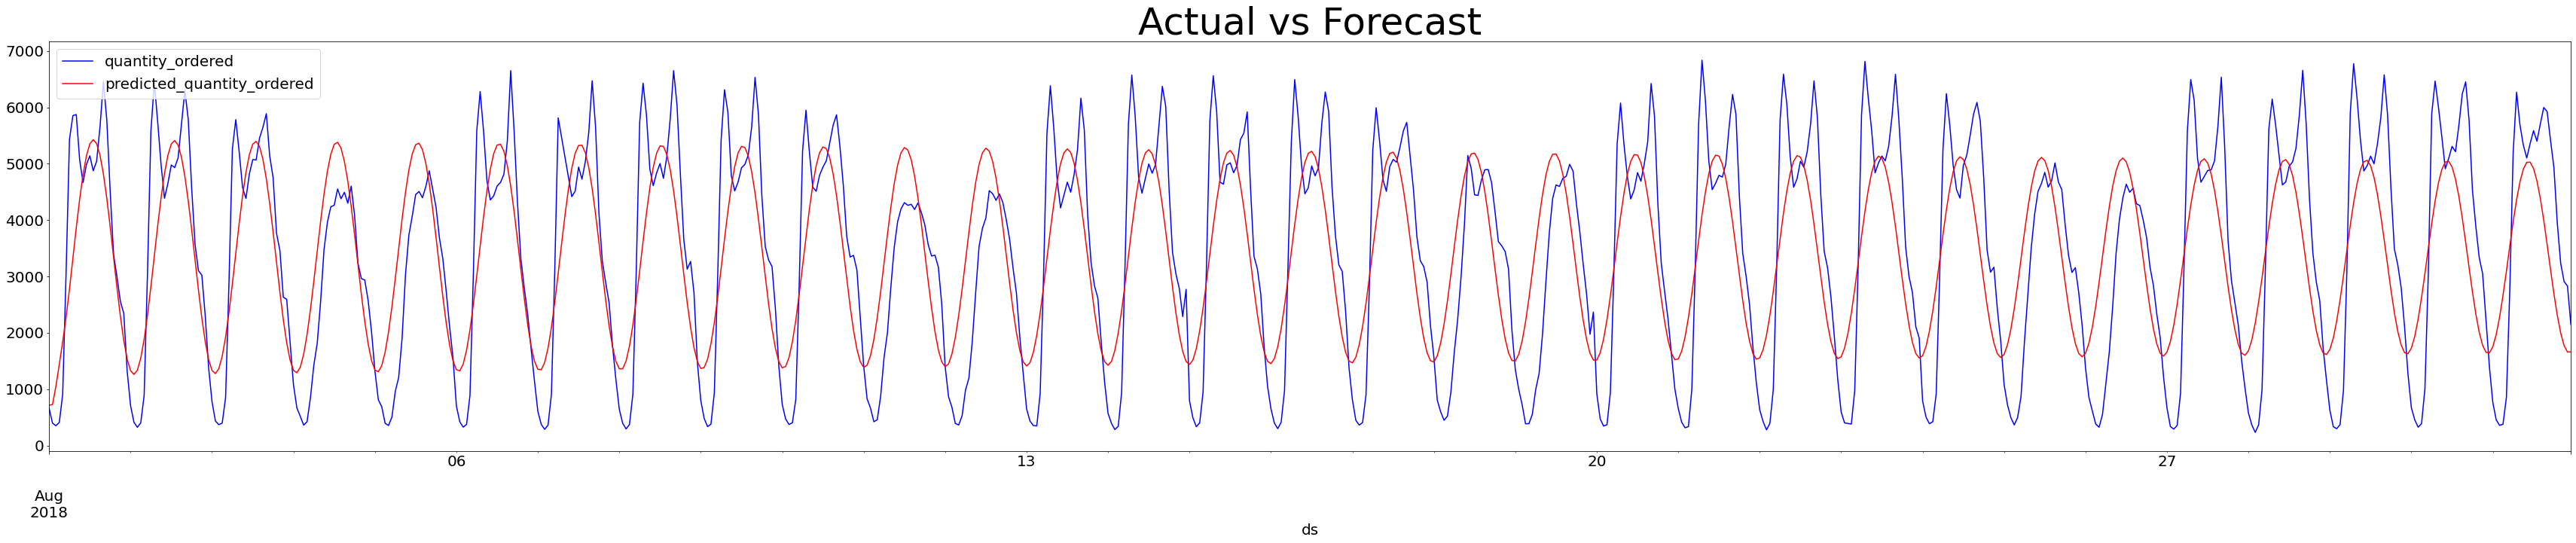

In [ ]:
plt.figure(figsize=(60, 10))
ax=plt.gca()
plt.legend(loc='upper left')
plt.title('Actual vs Forecast',fontdict = {'fontsize' : 50})
plt.rcParams.update({'font.size': 20})
testing_data_arima.plot( x='dsa' ,y= 'quantity_ordered',ax=ax,color='blue' )
prediction_df.plot( x='ds' ,y= 'predicted_quantity_ordered',ax=ax,color='red' )

You can further tune the parameters and perhaps add in seasonality (SARIMA) to improve the performance.

# Build Time Forecasting Model Using Facebook Prophet

Facebook Prophet is an open source tool for time series forecasting.  We are going to use Prophet to build a time series model.  Prophet is simple to use, and it has simple intuitive parameters.  In addition, it provides the options to include custom seasonality and holidays in model building.

Prophet works as a additive regression model.  It decomposes the time series into a linear/logistic trend, seasaonality and holiday effect.  For more information about Prophet, you can go to the 
[Prophet documentation](https://facebook.github.io/prophet/)

Let's first transform the data to what Prophet expects.   The timestamp data column has to be labeled as "ds" column and the target column has to be labeled as "y."

In [ ]:
data['y'] = data['quantity_ordered']
data_subset_ph = data[(data['date_time']>'2017-07-01') & (data['date_time']<'2018-08-01')]
data_subset_ph = data_subset_ph[['y', 'ds']]
data_subset_ph.reset_index(drop = True, inplace = True)

test_subset_ph = data[(data['date_time']>'2018-08-01') & (data['date_time']<'2018-09-01')]
test_subset_ph = test_subset_ph[['y', 'ds']]
test_subset_ph.reset_index(drop = True, inplace = True)


### Fit Prophet Model on Dataset

Let's first fit a model to our training data set and forecast the vehicle volume on the testing data datetime range.

In [ ]:
#Define model and fit to training data and return the forecast of the vehicle volume for the testing data
def return_forecast(prophet_model, training_data, testing_data_range):
    prophet_model.fit(training_data)
    forecast_data = prophet_model.predict(testing_data_range)
    return forecast_data

In [ ]:
prophet = Prophet()
prophet_forecast = return_forecast(prophet, data_subset_ph, test_subset_ph )


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Let's looking at the results. The column `yhat` is the forecasted value.  `yhat_lower` and `yhat_upper` represents the uncertainty interval, which is by default set to 80%.  For more information about it, you can read about it [here](https://facebook.github.io/prophet/docs/uncertainty_intervals.html)

In [ ]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2018-08-01 00:00:00,1406.333719,371.292703,2476.856286
1,2018-08-01 01:00:00,709.810007,-303.844502,1813.390177
2,2018-08-01 02:00:00,271.402066,-847.221052,1284.399389
3,2018-08-01 03:00:00,467.967702,-627.988655,1585.248209
4,2018-08-01 04:00:00,1391.921391,296.137832,2451.407460


You can plot the forecast components with `.plot_components` method. By default it will plot the trend and seasonality effects of the time series. 

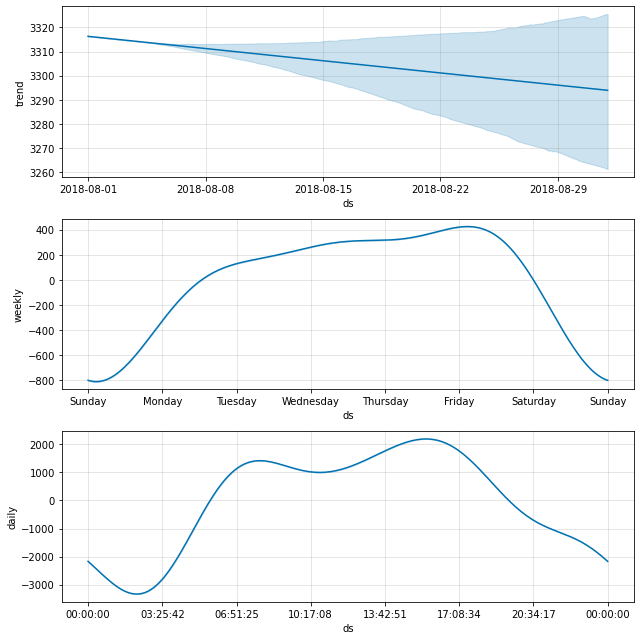

In [ ]:
fig = prophet.plot_components(prophet_forecast)

In [ ]:
def model_evaluation(actual_dataset, forecast_dataset, title):    
    plt.figure(figsize=(30, 7))
    plt.plot(actual_dataset['ds'], actual_dataset['y'], c= 'red', label = 'actual')
    plt.plot(forecast_dataset['ds'], forecast_dataset['yhat'], c= 'blue', label = 'predicted')
    plt.legend(loc='upper left')
    plt.title(title)
    plt.show()
    mae = mean_absolute_error(actual_dataset['y'], forecast_dataset['yhat'])
    rmse = np.sqrt(mean_squared_error(actual_dataset['y'], forecast_dataset['yhat']))
    mape = mean_absolute_percentage_error(actual_dataset['y'], forecast_dataset['yhat'])
    print('Model Performance')
    print('Test Mean Absolute Error:', mean_absolute_error(actual_dataset['y'], forecast_dataset['yhat']))
    print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(actual_dataset['y'], forecast_dataset['yhat'])))
    print('Test Mean Absolute percentage Error:',mean_absolute_percentage_error(actual_dataset['y'], forecast_dataset['yhat']))
    return mae, rmse, mape



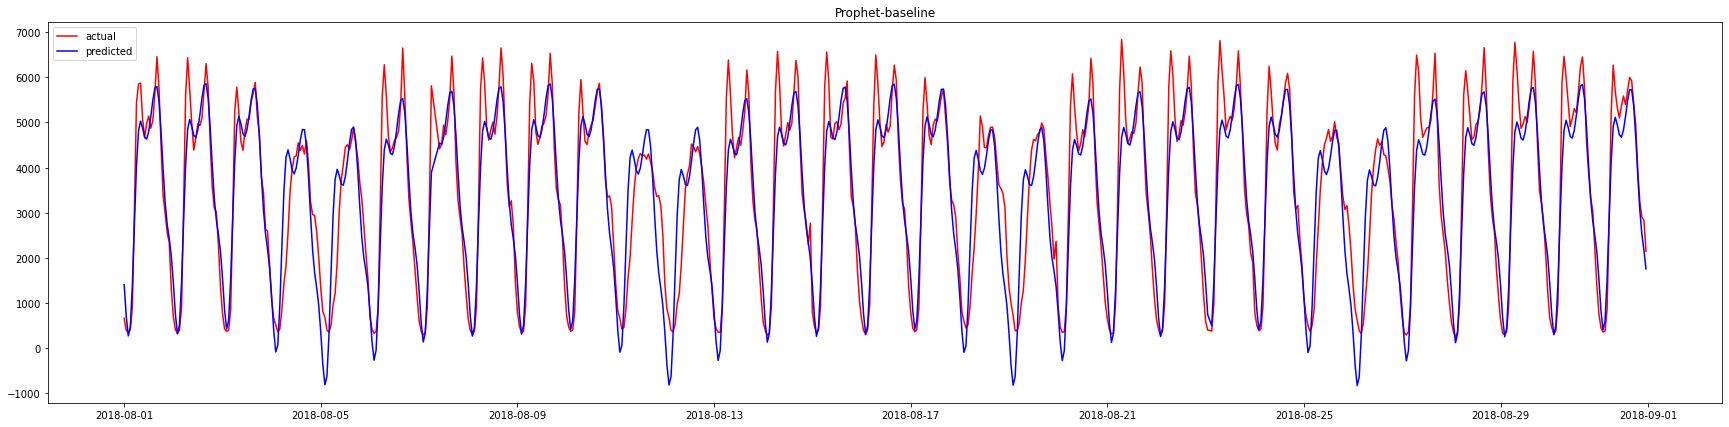

Model Performance
Test Mean Absolute Error: 528.3885808048626
Test Root Mean Squared Error: 738.2611239546294
Test Mean Absolute percentage Error: 30.689961409010092


In [ ]:
mae_ph, rmse_ph, mape_ph = model_evaluation(test_subset_ph, prophet_forecast, 'Prophet-baseline')


### Adding in the impact of holidays 

Prophet has built-in country-specific holidays which can be added as a component that impacts the forecasting model.  It is really simple to add in this functionality


In [ ]:
prophet_holiday=Prophet()
prophet_holiday.add_country_holidays(country_name = 'Kenya')

In [ ]:
prophet_holiday_forecast = return_forecast(prophet_holiday, data_subset_ph, test_subset_ph )

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

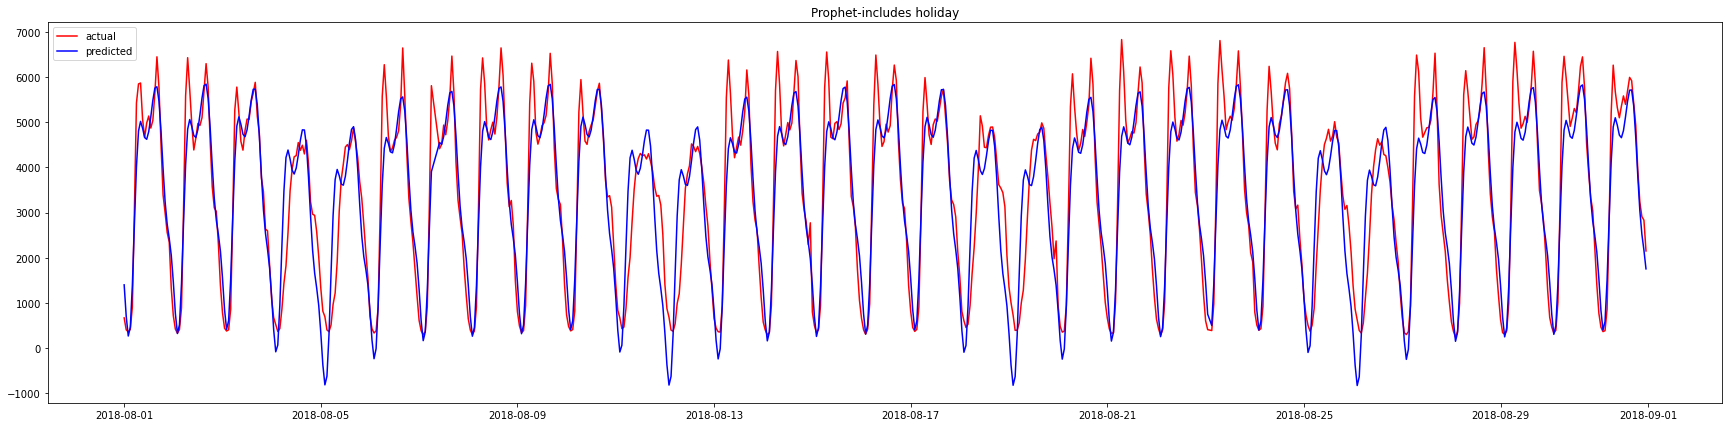

Model Performance
Test Mean Absolute Error: 527.3778877182438
Test Root Mean Squared Error: 737.1952529610703
Test Mean Absolute percentage Error: 30.49945335409071


In [ ]:
mae_ph_hol, rmse_ph_hol, mape_ph_hol = model_evaluation(test_subset_ph, prophet_holiday_forecast, 'Prophet-includes holiday')

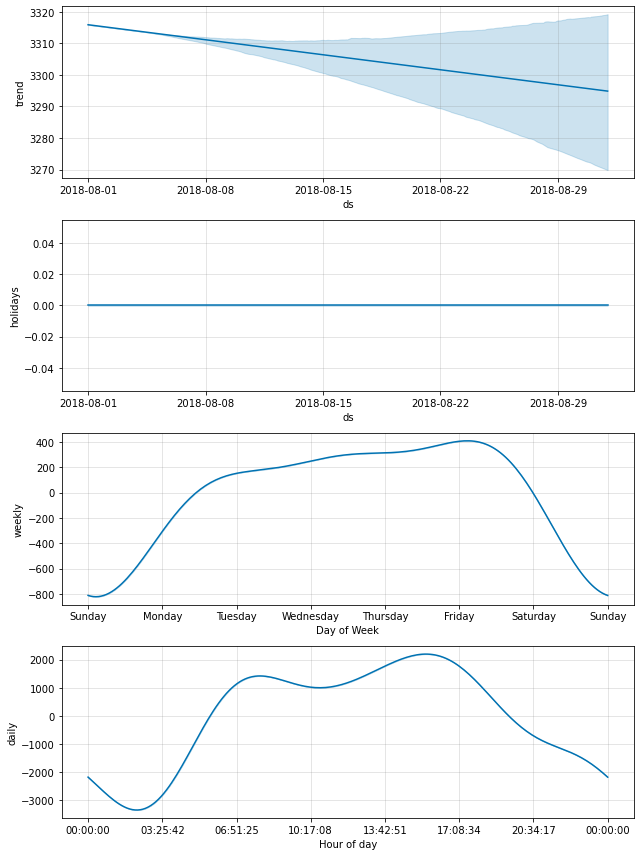

In [ ]:
fig2 = prophet_holiday.plot_components(prophet_holiday_forecast)


In [ ]:
def model_plot(og_dataset,actual_dataset, forecast_dataset, title):    
    plt.figure(figsize=(60, 10))
    plt.plot(og_dataset['ds'], og_dataset['quantity_ordered'], c= 'teal', label = 'Train')
    plt.plot(actual_dataset['ds'], actual_dataset['y'], c= 'red', label = 'Test')
    plt.plot(forecast_dataset['ds'], forecast_dataset['yhat'], c= 'blue', label = 'Forecast')
    plt.legend(loc='upper left')
    plt.title(title,fontdict = {'fontsize' : 50})
    plt.rcParams.update({'font.size': 20})
    plt.show()

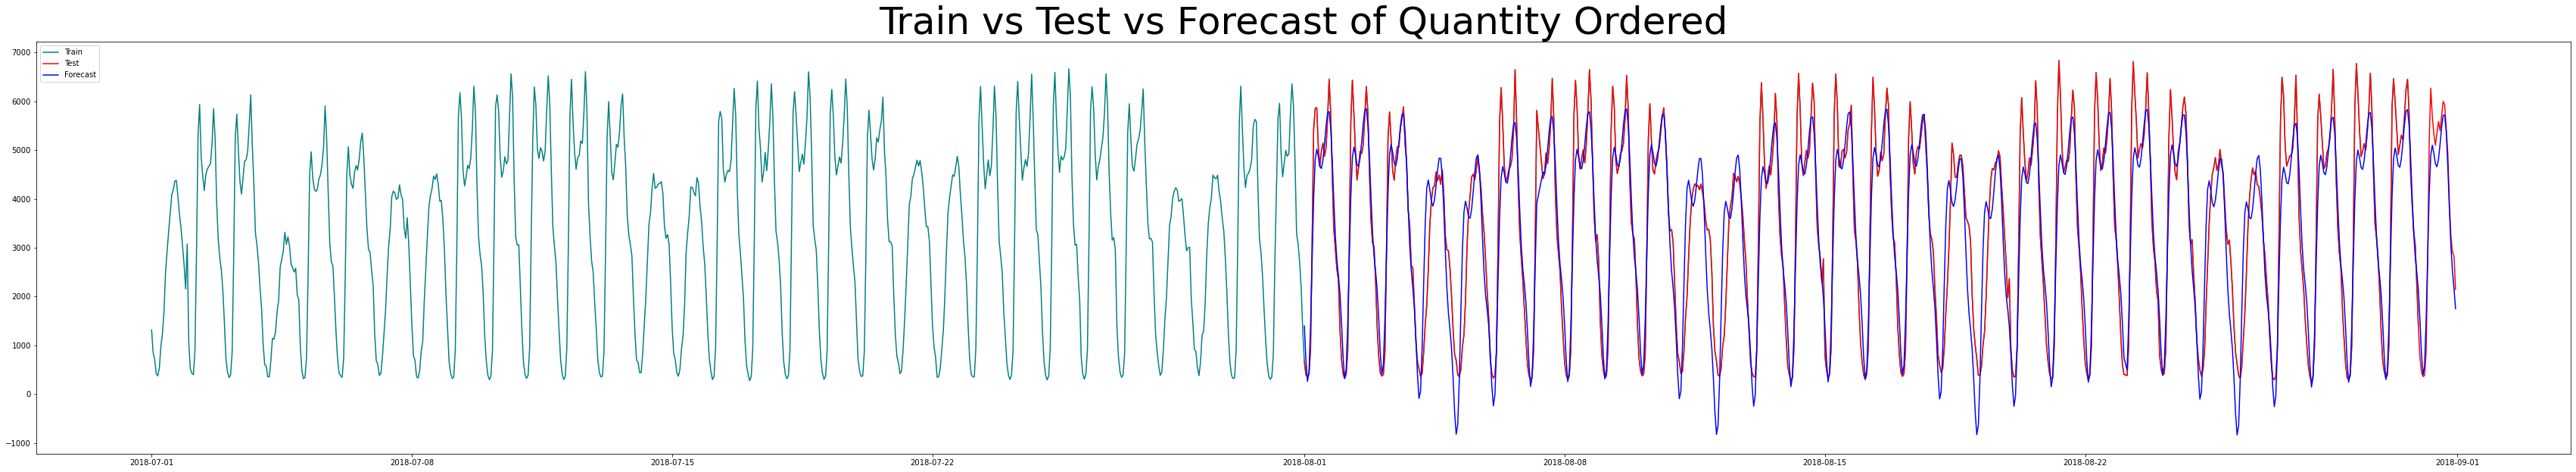

In [ ]:
model_plot(data_subset_plot,test_subset_ph,prophet_holiday_forecast,'Train vs Test vs Forecast of Quantity Ordered')

# Comparing Model Results

In [ ]:
data = {'arima baseline': [mae_arima, rmse_arima, mape_arima],
       'Prophet baseline': [mae_ph, rmse_ph, mape_ph],
       'Prophet w/ holiday': [mae_ph_hol, rmse_ph_hol, mape_ph_hol]}
result_df = pd.DataFrame(data, index =['MAE', 
                                'RMSE', 
                                'MAPE']) 

In [ ]:
result_df

,arima baseline,Prophet baseline,Prophet w/ holiday
MAE,1031.879502,528.388581,527.138894
RMSE,1263.022285,738.261124,732.640412
MAPE,80.839994,30.689961,30.934399


# Saving Model to Model Artifact

In [ ]:
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
import os
import json
from prophet.serialize import model_to_json
path_to_rf_artifact=f"./prophet-hmodel"
if not os.path.exists(path_to_rf_artifact):
	os.mkdir(path_to_rf_artifact)

In [ ]:
# serializing model
import json
from os import path
from prophet.serialize import model_to_json, model_from_json

with open(path.join(path_to_rf_artifact,'prophet_holiday.json'), 'w') as fout:
    json.dump(model_to_json(prophet_holiday), fout)  # Save model

with open('prophet_holiday.json', 'r') as fin:
    prophet_holiday = model_from_json(json.load(fin))  # Load model

In [ ]:
pub_conda='oci://jjabucket@bk/conda_environments/cpu/General Machine Learning for CPUs/1.0/mlcpuv1'
artifacth = prepare_generic_model(path_to_rf_artifact,function_artifacts=False, force_overwrite=True, inference_env=pub_conda)

loop1:   0%|          | 0/4 [00:00<?, ?it/s]

INFO:ADS:We give you the option to specify a different inference conda environment for model deployment purposes. By default it is assumed to be the same as the conda environment used to train the model. If you wish to specify a different environment for inference purposes, please assign the path of a published or data science conda environment to the optional parameter `inference_conda_env`. 


In [ ]:
artifacth

Artifact directory: ./prophet-hmodel
Contains: ['score.py', 'prophet_holiday.json', 'requirements.txt', 'runtime.yaml', '.ipynb_checkpoints', '.ipynb_checkpoints/score-checkpoint.py', '.ipynb_checkpoints/requirements-checkpoint.txt', '.ipynb_checkpoints/runtime-checkpoint.yaml']

In [ ]:
%%writefile {path_to_rf_artifact}/score.py

import json
import os
import pandas as pd
import io
import logging
from prophet.serialize import model_from_json

def load_model():
    
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    print(contents)
    #model_filename="prophet_holiday.json"
    if "prophet_holiday.json" in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)),"prophet_holiday.json" ), "r") as file:
            model=model_from_json(json.load(file))
    else:
        raise Exception('{0} is not found in model directory {1}'.format("prophet_holiday.json", model_dir))
    
    return model

def predict(data,model=load_model()) -> dict:
	assert model is not None, " Model unavailable"
	X=pd.read_json(io.StringIO(data)) if isinstance(data,str) else pd.DataFrame.from_dict(data)
	X=pd.DataFrame(pd.to_datetime(X['ds'],unit='ms'))
	X.sort_index(inplace=True)
	yhat=model.predict(X)['yhat']
	preds=X.merge(yhat,how='inner',left_index=True, right_index=True, sort=True)
	preds.set_index('ds',drop=True,inplace=True)

	return preds.to_json()


Overwriting ./prophet-hmodel/score.py


In [ ]:
# Create a default config using DEFAULT profile in default location
# Refer to
# https://docs.cloud.oracle.com/en-us/iaas/Content/API/Concepts/sdkconfig.htm#SDK_and_CLI_Configuration_File
# for more info
 
import oci
from oci.data_science.models import CreateModelDetails,CreateModelProvenanceDetails, UpdateModelDetails, UpdateModelProvenanceDetails
#import Metadata
config = oci.config.from_file()
data_science_client = oci.data_science.DataScienceClient(config=config)
 
# Initialize service client with user principal (config file)
#config = oci.config.from_file()
#data_science_client = oci.data_science.DataScienceClient(config=config)
 
# Alternatively initialize service client with resource principal (for example in a notebook session)
# auth = oci.auth.signers.get_resource_principals_signer()
# data_science_client = oci.data_science.DataScienceClient({}, signer=auth)


In [ ]:
provenance_details = CreateModelProvenanceDetails(repository_url="https://github.com/jeffy97/ormc",
                                                  git_branch="ormc",
                                                  git_commit="--amend",
                                                  script_dir="/home/datascience/conda/notebooks/mlcpuv1/forecast",training_script='/home/datascience/conda/notebooks/mlcpuv1/forecast/time-series-scm.ipynb'
                                                )


In [ ]:
provenance_details

{
  "git_branch": "ormc",
  "git_commit": "--amend",
  "repository_url": "https://github.com/jeffy97/ormc",
  "script_dir": "/home/datascience/conda/notebooks/mlcpuv1/forecast",
  "training_script": "/home/datascience/conda/notebooks/mlcpuv1/forecast/time-series-scm.ipynb"
}

In [ ]:
catalog_entry=artifacth.save(display_name='prophet-holiday',description='holiday prophet model')

In [ ]:
catalog_entry=artifacth.save(display_name='prophet-holiday-g',description='holiday prophet model',training_script_path='/home/datascience/conda/notebooks/mlcpuv1/forecast/time-series-scm.ipynb',provenance_metadata=provenance_details)

INFO:ADS:{
  "git_branch": "None",
  "git_commit": "None",
  "repository_url": "None",
  "script_dir": "/home/datascience/conda/notebooks/mlcpuv1/forecast/prophet-hmodel",
  "training_script": "/home/datascience/conda/notebooks/mlcpuv1/forecast/time-series-scm.ipynb"
}


loop1:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#https://github.com/oracle/oci-data-science-ai-samples/tree/master/model_catalog_examples/artifact_boilerplate

In [ ]:
'''
import json
from json import load
# Declare input/output schema for our model - this is optional
# It must be a valid json or yaml string
# Schema like model artifact is immutable hence it is allowed only at the model creation time and cannot be updated
# Schema json sample in appendix
input_schema = load(open('SR_input_schema.json','rb'))
input_schema_str= json.dumps(input_schema)
output_schema = load(open('SR_output_schema.json','rb'))
output_schema_str= json.dumps(output_schema)
'''

"\nimport json\nfrom json import load\n# Declare input/output schema for our model - this is optional\n# It must be a valid json or yaml string\n# Schema like model artifact is immutable hence it is allowed only at the model creation time and cannot be updated\n# Schema json sample in appendix\ninput_schema = load(open('SR_input_schema.json','rb'))\ninput_schema_str= json.dumps(input_schema)\noutput_schema = load(open('SR_output_schema.json','rb'))\noutput_schema_str= json.dumps(output_schema)\n"

In [ ]:
%%bash

pwd

/home/datascience/conda/notebooks/mlcpuv1/forecast


In [ ]:
# creating a model details object:
model_details = CreateModelDetails(
    compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'],
    project_id=os.environ['PROJECT_OCID'],
    display_name='prophet-holiday-g',
    description='holiday prophet git')
 
# creating the model object:
model = data_science_client.create_model(model_details)
# adding the provenance:
data_science_client.create_model_provenance(model.data.id, provenance_details)
# adding the artifact:
with open('/home/datascience/conda/notebooks/mlcpuv1/forecast/prophet-hmodelzip.zip','rb') as artifact_file:
    artifact_bytes = artifact_file.read()
    data_science_client.create_model_artifact(model.data.id, artifact_bytes, content_disposition='attachment; filename="{model.data.id}.zip"')


## Prediction with the artifact

In [ ]:
import sys
sys.path.insert(0,path_to_rf_artifact)

from score import load_model,predict
test=pd.DataFrame(test_subset_ph['ds'][:10]).to_json()

_=load_model()
predictions_test=predict(test,_)

['__pycache__', 'score.py', 'prophet_holiday.json', 'requirements.txt', 'runtime.yaml']


In [ ]:
predictions_test

'{"yhat":{"1533081600000":1395.4604606027,"1533085200000":698.7942367987,"1533088800000":260.3640156568,"1533092400000":457.0192182022,"1533096000000":1381.1685153166,"1533099600000":2737.2198977985,"1533103200000":4015.4531135189,"1533106800000":4806.9866117311,"1533110400000":5021.8089600924,"1533114000000":4870.1458712557}}'

## Invoking the model

In [ ]:
input_df=pd.DataFrame(test_subset_ph['ds'][:10])

In [ ]:
input_data=input_df.to_json()

In [ ]:
endpoint='https://modeldeployment.us-ashburn-1.oci.customer-oci.com/ocid1.datasciencemodeldeployment.oc1.iad.id/predict'

In [ ]:
# The OCI SDK must be installed for this example to function properly.
# Installation instructions can be found here: https://docs.oracle.com/en-us/iaas/Content/API/SDKDocs/pythonsdk.htm

import requests
import oci
from oci.signer import Signer

config = oci.config.from_file("~/.oci/config") # replace with the location of your oci config file
auth = Signer(
  tenancy=config['tenancy'],
  user=config['user'],
  fingerprint=config['fingerprint'],
  private_key_file_location=config['key_file'],
  pass_phrase=config['pass_phrase'])

body = input_data # payload goes here

response=requests.post(endpoint, json=body, auth=auth).json()

In [ ]:
response

'{"yhat":{"1533081600000":1395.4604606027,"1533085200000":698.7942367987,"1533088800000":260.3640156568,"1533092400000":457.0192182022,"1533096000000":1381.1685153166,"1533099600000":2737.2198977985,"1533103200000":4015.4531135189,"1533106800000":4806.9866117311,"1533110400000":5021.8089600924,"1533114000000":4870.1458712557}}'

In [ ]:
def NestedDictValues(d):
  for v in d.values():
    if isinstance(v, dict):
      yield from NestedDictValues(v)
    else:
      yield v
resp_json = json.loads(response)    
resp_list=list(NestedDictValues(resp_json))

In [ ]:
date_list=input_df['ds'].tolist()

In [ ]:
invokedf = pd.DataFrame(list(zip(date_list,resp_list)),columns=['Shipment_Date','Forecasted_Quantity_Ordered'])

In [ ]:
invokedf.head()

,Shipment_Date,Forecasted_Quantity_Ordered
0,2018-08-01 00:00:00,1395.460461
1,2018-08-01 01:00:00,698.794237
2,2018-08-01 02:00:00,260.364016
3,2018-08-01 03:00:00,457.019218
4,2018-08-01 04:00:00,1381.168515


In [2]:
'''
/*
** MyWidget version 1.0.
**
** Copyright (c) 2015 WidgetCo, Inc.
**
** The Universal Permissive License (UPL), Version 1.0
**
** Subject to the condition set forth below, permission is hereby granted to any
** person obtaining a copy of this software, associated documentation and/or data
** (collectively the "Software"), free of charge and under any and all copyright
** rights in the Software, and any and all patent rights owned or freely
** licensable by each licensor hereunder covering either (i) the unmodified
** Software as contributed to or provided by such licensor, or (ii) the Larger
** Works (as defined below), to deal in both
** 
** (a) the Software, and
** (b) any piece of software and/or hardware listed in the lrgrwrks.txt file if
** one is included with the Software (each a "Larger Work" to which the Software
** is contributed by such licensors),
** 
** without restriction, including without limitation the rights to copy, create
** derivative works of, display, perform, and distribute the Software and make,
** use, sell, offer for sale, import, export, have made, and have sold the
** Software and the Larger Work(s), and to sublicense the foregoing rights on
** either these or other terms.
** 
** This license is subject to the following condition:
** The above copyright notice and either this complete permission notice or at
** a minimum a reference to the UPL must be included in all copies or
** substantial portions of the Software.
** 
** THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
** IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
** FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
** AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
** LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
** OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
** SOFTWARE.
'''

'\n/*\n** MyWidget version 1.0.\n**\n** Copyright (c) 2015 WidgetCo, Inc.\n**\n** The Universal Permissive License (UPL), Version 1.0\n**\n** Subject to the condition set forth below, permission is hereby granted to any\n** person obtaining a copy of this software, associated documentation and/or data\n** (collectively the "Software"), free of charge and under any and all copyright\n** rights in the Software, and any and all patent rights owned or freely\n** licensable by each licensor hereunder covering either (i) the unmodified\n** Software as contributed to or provided by such licensor, or (ii) the Larger\n** Works (as defined below), to deal in both\n** \n** (a) the Software, and\n** (b) any piece of software and/or hardware listed in the lrgrwrks.txt file if\n** one is included with the Software (each a "Larger Work" to which the Software\n** is contributed by such licensors),\n** \n** without restriction, including without limitation the rights to copy, create\n** derivative work